In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, add
from tensorflow.keras.utils import plot_model

In [ ]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Facial_expression/fer2013.csv/fer2013.csv',names=names, na_filter=False)
df = df.iloc[1:]
df.head()

,emotion,pixels,usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
import cv2
import os

# Define the directory containing the dataset
dataset_directory = '/content/drive/MyDrive/Facial_expression/New_Data/'

# Get a list of all image files in the directory
image_files = os.listdir(dataset_directory)

# Create an empty list to store grayscale images
grayscale_images = []

# Iterate over each image file
for file_name in image_files:
    # Construct the file path
    file_path = os.path.join(dataset_directory, file_name)

    # Load the image in grayscale
    image = cv2.imread(file_path, 0)

    # Add the grayscale image to the list
    grayscale_images.append(image)

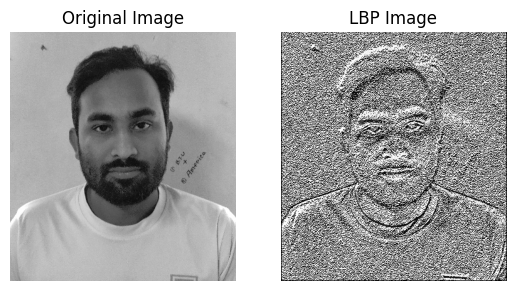

In [ ]:
# Load the grayscale image
image = cv2.imread('/content/drive/MyDrive/Facial_expression/New_Data/28.jpg', 0)

# Define the LBP parameters
radius = 1
neighbors = 8

# Compute the LBP image
lbp = np.zeros_like(image)
height, width = image.shape
for y in range(radius, height - radius):
    for x in range(radius, width - radius):
        center = image[y, x]
        code = 0
        for i in range(neighbors):
            angle = 2 * np.pi * i / neighbors
            x_i = int(x + radius * np.cos(angle))
            y_i = int(y + radius * np.sin(angle))
            if image[y_i, x_i] >= center:
                code |= (1 << i)
        lbp[y, x] = code

# Display the original image and the computed LBP image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Image')
plt.axis('off')

plt.show()

In [ ]:
def get_train_data(df):
    x = []

    train = df['pixels'].to_numpy()

    for i in range(len(train)):
        x.append(train[i].split(' '))

    x = np.array(x)
    x = x.astype('float32').reshape(len(train), 48, 48, 1)

    return x

In [ ]:
train = get_train_data(df)
labels = df['emotion'].to_numpy().astype('int')

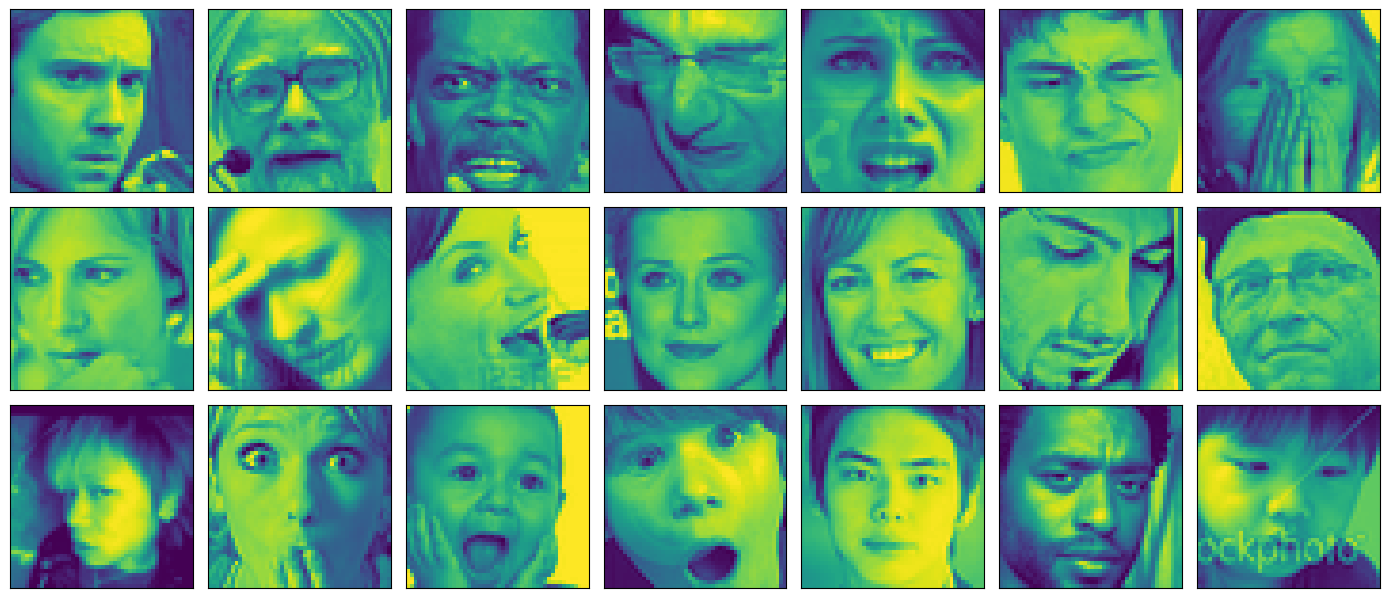

In [ ]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.1, random_state=42)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
X_train.shape

(32298, 48, 48, 1)

In [ ]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
time_callback_vgg = TimeHistory()
time_callback_incep = TimeHistory()
time_callback_resid = TimeHistory()
time_callback_cnn =TimeHistory()

In [ ]:
#CNN Model
basemodel =tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape =(48,48,1)),
                                       tf.keras.layers.MaxPool2D(2,2),
                                       tf.keras.layers.BatchNormalization(),
                                       #
                                       tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape = (48,48,1)),
                                       tf.keras.layers.MaxPool2D(2,2),
                                       tf.keras.layers.BatchNormalization(),
                                       #
                                       tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape = (48,48,1)),
                                       tf.keras.layers.MaxPool2D(2,2),
                                       tf.keras.layers.BatchNormalization(),
                                       #
                                       tf.keras.layers.Flatten(),
                                       tf.keras.layers.Dense(128,activation='relu'),
                                       tf.keras.layers.Dense(7,activation = 'softmax')])


In [ ]:
basemodel = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Block 4
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Block 5
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Flatten and fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])


In [ ]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss ='categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [ ]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 mode='max')

In [ ]:
basemodel.fit(X_train,y_train,epochs=110,validation_split=.1,callbacks=call_back)

Epoch 1/110
909/909 [==============================] - ETA: 0s - loss: 1.5221 - accuracy: 0.4092
Epoch 1: val_accuracy improved from -inf to 0.38483, saving model to checkpoint/best_model.h5
909/909 [==============================] - 58s 48ms/step - loss: 1.5221 - accuracy: 0.4092 - val_loss: 1.6978 - val_accuracy: 0.3848
Epoch 2/110
908/909 [============================>.] - ETA: 0s - loss: 1.2275 - accuracy: 0.5333
Epoch 2: val_accuracy improved from 0.38483 to 0.53313, saving model to checkpoint/best_model.h5
909/909 [==============================] - 39s 43ms/step - loss: 1.2276 - accuracy: 0.5333 - val_loss: 1.2496 - val_accuracy: 0.5331
Epoch 3/110
908/909 [============================>.] - ETA: 0s - loss: 1.0853 - accuracy: 0.5932
Epoch 3: val_accuracy improved from 0.53313 to 0.55263, saving model to checkpoint/best_model.h5
909/909 [==============================] - 42s 46ms/step - loss: 1.0853 - accuracy: 0.5932 - val_loss: 1.1859 - val_accuracy: 0.5526
Epoch 4/110
909/909 [=

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

y_pred = np.argmax(basemodel.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 score:", f1)

113/113 [==============================] - 2s 15ms/step
F1 score: 0.6187408839981577


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       498
           1       0.62      0.44      0.52        52
           2       0.56      0.43      0.48       545
           3       0.77      0.84      0.80       881
           4       0.50      0.54      0.52       588
           5       0.75      0.76      0.75       414
           6       0.60      0.57      0.58       611

    accuracy                           0.62      3589
   macro avg       0.61      0.58      0.59      3589
weighted avg       0.62      0.62      0.62      3589



113/113 [==============================] - 2s 15ms/step


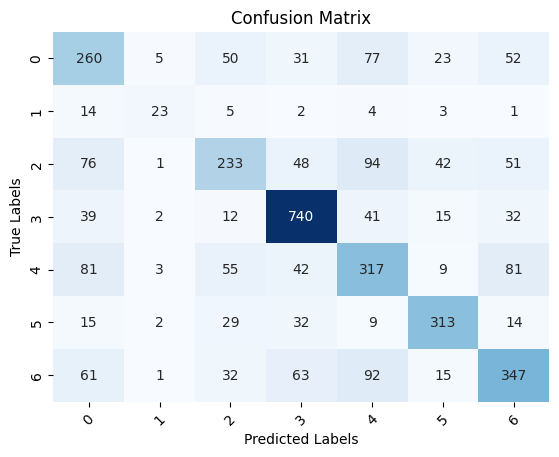

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(basemodel.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

labels = ['Class 1', 'Class 2', 'Class 3']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()


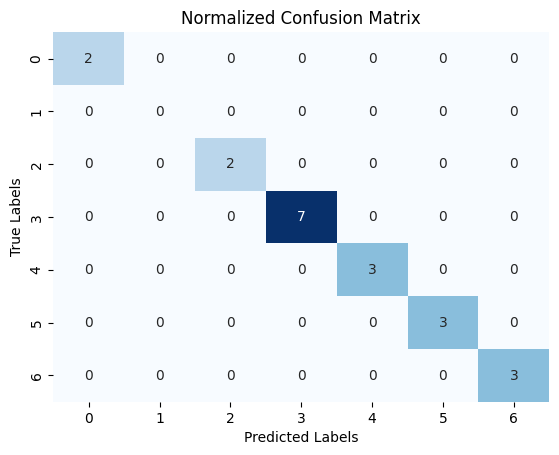

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your confusion matrix stored in the variable 'cm'
scalar = 100  # Scalar value for division

# Divide each element of the confusion matrix by the scalar value and convert to integers
normalized_cm = (cm / scalar).astype(int)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap of the normalized confusion matrix
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')

# Display the plot
plt.show()




In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Define model input
visible = Input(shape=(48, 48, 1))

# Add the first convolutional block
layer = Conv2D(64, (3, 3), padding='same', activation='relu')(visible)
layer = Conv2D(64, (3, 3), padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2), strides=(2, 2))(layer)

# Add the second convolutional block
layer = Conv2D(128, (3, 3), padding='same', activation='relu')(layer)
layer = Conv2D(128, (3, 3), padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2), strides=(2, 2))(layer)

# Add the third convolutional block
layer = Conv2D(256, (3, 3), padding='same', activation='relu')(layer)
layer = Conv2D(256, (3, 3), padding='same', activation='relu')(layer)
layer = Conv2D(256, (3, 3), padding='same', activation='relu')(layer)
layer = Conv2D(256, (3, 3), padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2), strides=(2, 2))(layer)

# Flatten the feature maps
layer = Flatten()(layer)

# Add a fully connected layer
layer = Dense(7, activation='softmax')(layer)

# Create the model
model_cnn = Model(inputs=visible, outputs=layer)

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history_cnn=model_cnn.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

Epoch 1/30
807/808 [============================>.] - ETA: 0s - loss: 1.8505 - accuracy: 0.2493
Epoch 1: val_accuracy did not improve from 0.58899
808/808 [==============================] - 21s 21ms/step - loss: 1.8505 - accuracy: 0.2492 - val_loss: 1.8220 - val_accuracy: 0.2421
Epoch 2/30
805/808 [============================>.] - ETA: 0s - loss: 1.7724 - accuracy: 0.2740
Epoch 2: val_accuracy did not improve from 0.58899
808/808 [==============================] - 16s 19ms/step - loss: 1.7723 - accuracy: 0.2742 - val_loss: 1.6662 - val_accuracy: 0.3546
Epoch 3/30
807/808 [============================>.] - ETA: 0s - loss: 1.5078 - accuracy: 0.4155
Epoch 3: val_accuracy did not improve from 0.58899
808/808 [==============================] - 16s 20ms/step - loss: 1.5079 - accuracy: 0.4155 - val_loss: 1.4178 - val_accuracy: 0.4639
Epoch 4/30
805/808 [============================>.] - ETA: 0s - loss: 1.3476 - accuracy: 0.4845
Epoch 4: val_accuracy did not improve from 0.58899
808/808 [====

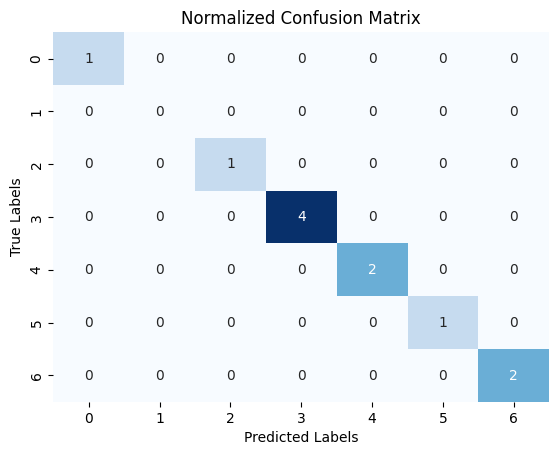

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your confusion matrix stored in the variable 'cm'
scalar = 300  # Scalar value for division

# Divide each element of the confusion matrix by the scalar value and convert to integers
normalized_cm = (cm / scalar).astype(int)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap of the normalized confusion matrix
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')

# Display the plot
plt.show()


225/225 [==============================] - 2s 6ms/step


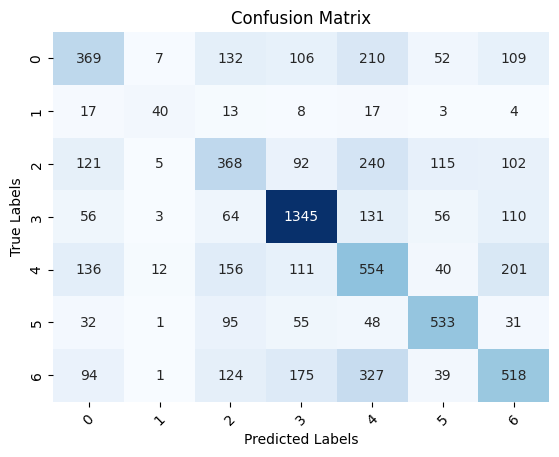

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict labels for the test data
y_pred = np.argmax(model_cnn.predict(X_test), axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your own class labels

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Predict labels for the test data
y_pred = np.argmax(model_cnn.predict(X_test), axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the F1 score
print("F1 score:", f1)


225/225 [==============================] - 1s 6ms/step
F1 score: 0.5160079424137586


In [ ]:
def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

In [ ]:
# define model input
visible = Input(shape=(48, 48, 1))
# add vgg module
layer = vgg_block(visible, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 4)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_vgg = Model(inputs=visible, outputs=layer)
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_vgg=model_vgg.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

Epoch 1/30
807/808 [============================>.] - ETA: 0s - loss: 1.8534 - accuracy: 0.2680
Epoch 1: val_accuracy did not improve from 0.58899
808/808 [==============================] - 20s 20ms/step - loss: 1.8532 - accuracy: 0.2680 - val_loss: 1.7207 - val_accuracy: 0.3400
Epoch 2/30
808/808 [==============================] - ETA: 0s - loss: 1.5395 - accuracy: 0.4050
Epoch 2: val_accuracy did not improve from 0.58899
808/808 [==============================] - 16s 19ms/step - loss: 1.5395 - accuracy: 0.4050 - val_loss: 1.4497 - val_accuracy: 0.4570
Epoch 3/30
805/808 [============================>.] - ETA: 0s - loss: 1.3830 - accuracy: 0.4714
Epoch 3: val_accuracy did not improve from 0.58899
808/808 [==============================] - 16s 19ms/step - loss: 1.3825 - accuracy: 0.4716 - val_loss: 1.3453 - val_accuracy: 0.4897
Epoch 4/30
808/808 [==============================] - ETA: 0s - loss: 1.2783 - accuracy: 0.5138
Epoch 4: val_accuracy did not improve from 0.58899
808/808 [====

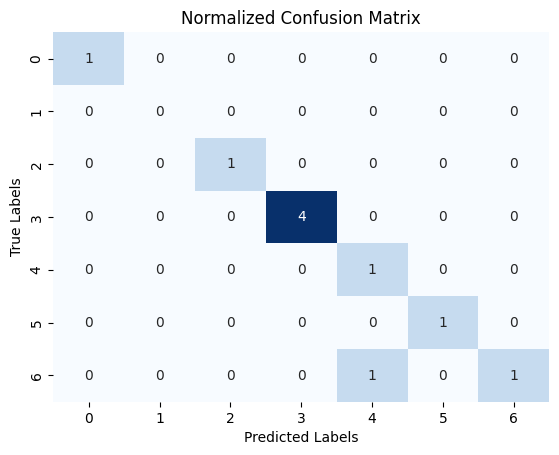

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your confusion matrix stored in the variable 'cm'
scalar = 300  # Scalar value for division

# Divide each element of the confusion matrix by the scalar value and convert to integers
normalized_cm = (cm / scalar).astype(int)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap of the normalized confusion matrix
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')

# Display the plot
plt.show()


225/225 [==============================] - 2s 6ms/step


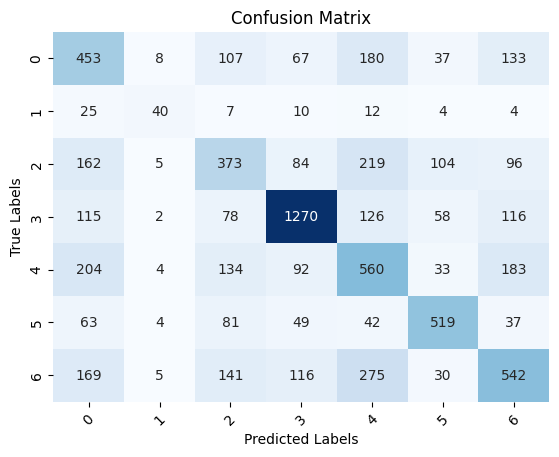

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict labels for the test data
y_pred = np.argmax(model_vgg.predict(X_test), axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your own class labels

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.46      0.42       985
           1       0.59      0.39      0.47       102
           2       0.40      0.36      0.38      1043
           3       0.75      0.72      0.74      1765
           4       0.40      0.46      0.43      1210
           5       0.66      0.65      0.66       795
           6       0.49      0.42      0.45      1278

    accuracy                           0.52      7178
   macro avg       0.52      0.50      0.51      7178
weighted avg       0.53      0.52      0.53      7178



In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Predict labels for the test data
y_pred = np.argmax(model_vgg.predict(X_test), axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the F1 score
print("F1 score:", f1)

225/225 [==============================] - 1s 6ms/step
F1 score: 0.5113979048718152


In [ ]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [ ]:
# define model input
visible = Input(shape=(48, 48, 1))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_inception = Model(inputs=visible, outputs=layer)
model_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_inception=model_inception.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

NameError: ignored

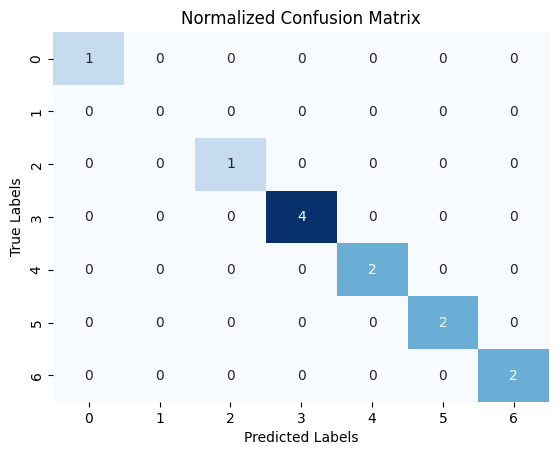

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your confusion matrix stored in the variable 'cm'
scalar = 300  # Scalar value for division

# Divide each element of the confusion matrix by the scalar value and convert to integers
normalized_cm = (cm / scalar).astype(int)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap of the normalized confusion matrix
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')

# Display the plot
plt.show()


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Predict labels for the test data
y_pred = np.argmax(model_vgg.predict(X_test), axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the F1 score
print("F1 score:", f1)

225/225 [==============================] - 1s 6ms/step
F1 score: 0.5313112858806078


In [ ]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [ ]:
# define model input
visible = Input(shape=(48, 48, 1))
# add vgg module
layer = residual_module(visible, 64)
# create model

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_residual = Model(inputs=visible, outputs=layer)
model_residual.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_residual=model_residual.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

Epoch 1/30
805/808 [============================>.] - ETA: 0s - loss: 0.9209 - accuracy: 0.6474
Epoch 1: val_accuracy did not improve from 0.56252
808/808 [==============================] - 9s 11ms/step - loss: 0.9205 - accuracy: 0.6475 - val_loss: 11.7199 - val_accuracy: 0.2557
Epoch 2/30
803/808 [============================>.] - ETA: 0s - loss: 0.8949 - accuracy: 0.6574
Epoch 2: val_accuracy did not improve from 0.56252
808/808 [==============================] - 8s 10ms/step - loss: 0.8951 - accuracy: 0.6572 - val_loss: 11.6968 - val_accuracy: 0.2529
Epoch 3/30
802/808 [============================>.] - ETA: 0s - loss: 0.8772 - accuracy: 0.6684
Epoch 3: val_accuracy did not improve from 0.56252
808/808 [==============================] - 8s 10ms/step - loss: 0.8765 - accuracy: 0.6684 - val_loss: 12.4111 - val_accuracy: 0.2546
Epoch 4/30
804/808 [============================>.] - ETA: 0s - loss: 0.8333 - accuracy: 0.6805
Epoch 4: val_accuracy did not improve from 0.56252
808/808 [====

KeyboardInterrupt: ignored

225/225 [==============================] - 1s 4ms/step


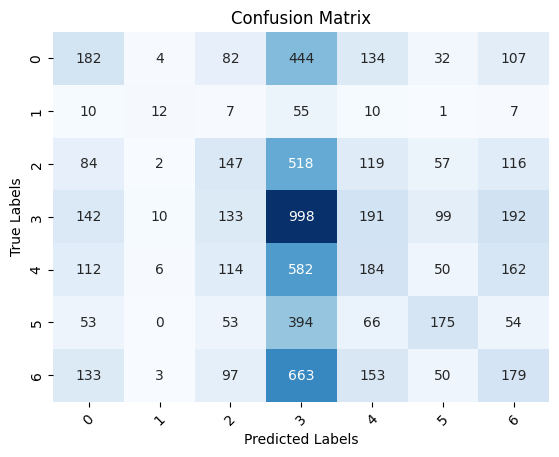

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict labels for the test data
y_pred = np.argmax(model_residual.predict(X_test), axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your own class labels

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Predict labels for the test data
y_pred = np.argmax(model_residual.predict(X_test), axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the F1 score
print("F1 score:", f1)

225/225 [==============================] - 1s 4ms/step
F1 score: 0.23910330183368333


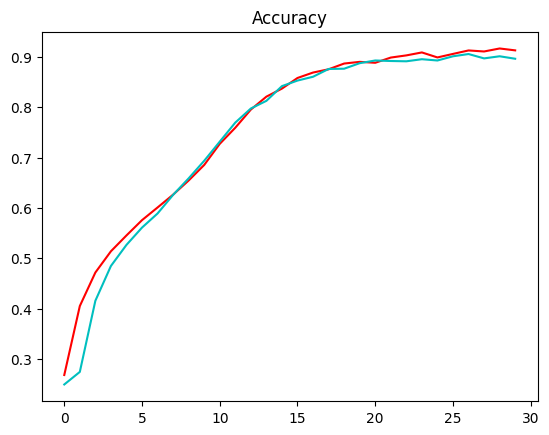

In [ ]:
plt.title("Accuracy")
#plt.plot(history_residual.history['accuracy'], 'b')
#plt.plot(history_inception.history['accuracy'], 'g')
plt.plot(history_vgg.history['accuracy'], 'r')
plt.plot(history_cnn.history['accuracy'], 'c')

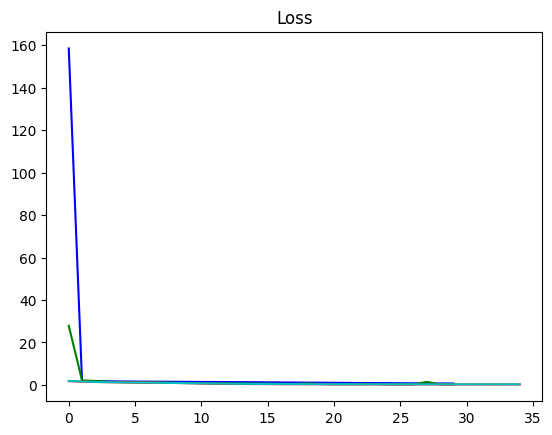

In [ ]:
plt.title("Loss")
plt.plot(history_residual.history['loss'], 'b')
plt.plot(history_inception.history['loss'], 'g')
plt.plot(history_vgg.history['loss'], 'r')
plt.plot(history_cnn.history['loss'], 'c')

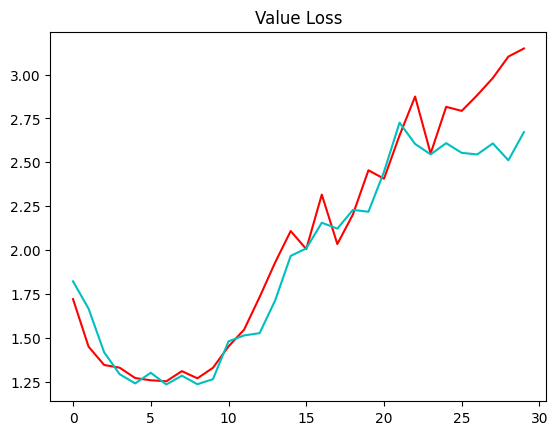

In [ ]:
plt.title("Value Loss")
#plt.plot(history_residual.history['val_loss'], 'b')
#plt.plot(history_inception.history['val_loss'], 'g')
plt.plot(history_vgg.history['val_loss'], 'r')
plt.plot(history_cnn.history['val_loss'], 'c')

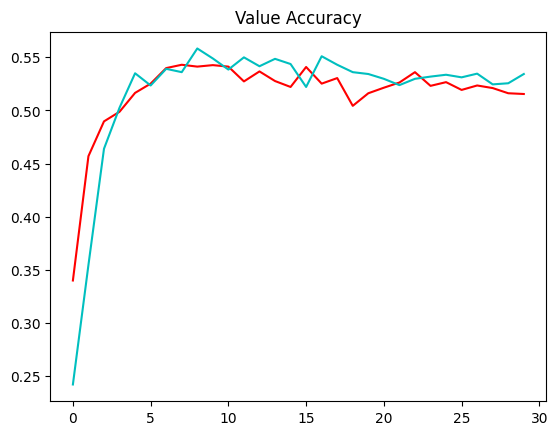

In [ ]:
plt.title("Value Accuracy")
#plt.plot(history_residual.history['val_accuracy'], 'b')
#plt.plot(history_inception.history['val_accuracy'], 'g')
plt.plot(history_vgg.history['val_accuracy'], 'r')
plt.plot(history_cnn.history['val_accuracy'], 'c')

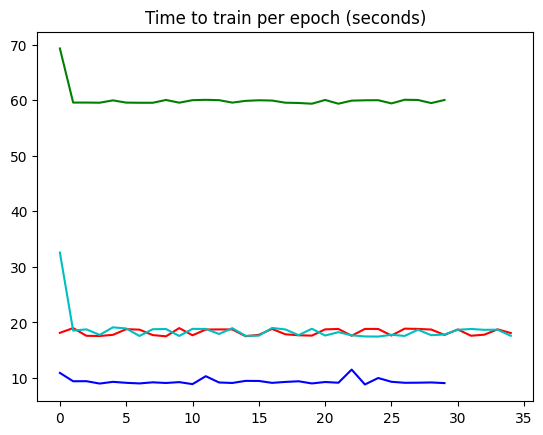

In [ ]:
plt.title("Time to train per epoch (seconds)")
plt.plot(time_callback_resid.times, 'b')
plt.plot(time_callback_incep.times, 'g')
plt.plot(time_callback_vgg.times, 'r')
plt.plot(time_callback_cnn.times, 'c')